# Description

Link [here](https://www.kaggle.com/c/nlp-getting-started/overview)

# Contents

# Getting Data From Kaggle via API <a name="getting-kaggle-data"></a>

In [ ]:
! pip install -q kaggle

In [ ]:
import os

os.chdir('/content/drive/MyDrive/Hackerearth/Disaster Tweet')
os.getcwd()

'/content/drive/MyDrive/Hackerearth/Disaster Tweet'

In [ ]:
from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d vstepanenko/disaster-tweets

  0% 0.00/656k [00:00<?, ?B/s]
100% 656k/656k [00:00<00:00, 44.0MB/s]


In [ ]:
! unzip disaster-tweets.zip

Archive:  disaster-tweets.zip
  inflating: tweets.csv              


# Play Around with data <a name="play-with-data"></a>

### Explore Data

In [1]:
WORKING_DIR = '/content/drive/MyDrive/Hackerearth/Disaster Tweet'

import os
os.chdir(WORKING_DIR)

from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

<IPython.core.display.Javascript object>

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np
import torch 
import torch.nn as nn
import torchtext
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# imbalanced dataset, more negative samples than positive samples

df.groupby('target').count()

,id,keyword,location,text
target,,,,
0,4342,4323,2884,4342
1,3271,3229,2196,3271


In [5]:
len(df['keyword'].unique()), len(df)

(222, 7613)

### Preprocessing using torchtext

In [6]:
from torchtext import data  

In [7]:
import re
import string 

def clean_text(text):
    text = text.lower()
    #foction de replacement
    text = re.sub(r"i'm","i am",text)
    text = re.sub(r"she's","she is",text)
    text = re.sub(r"can't","can not",text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r"[-()\"#/@;:<>{}=~|.?!,]", "", text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [8]:
# df['text'] = df['text'].map(clean_text)

# df.to_csv('cleaned tweets.csv', index=False)

In [9]:
# x = pd.read_csv('test.csv')
# x['text'] = x['text'].map(clean_text)
# x.to_csv('cleaned test.csv', index=False)

In [10]:
# Denotes the transformatioin to be applied

Text = data.Field(sequential=True, use_vocab=True, tokenize='spacy', batch_first=True)
Labels = data.LabelField(dtype=torch.float, batch_first=True, use_vocab=False)

In [11]:
# which cols to consider and how, in the dataset, and which transformation to apply

fields = {'text': ('text', Text), 'target': ('label', Labels)}

In [12]:
# loading custom dataset
training_data=data.TabularDataset(path = 'cleaned tweets.csv',format = 'csv',fields = fields)

In [13]:
import random
# for now, random split, will look for ways to stratify the split
train_data, valid_data = training_data.split(split_ratio=0.7)

In [14]:
# build vocabulary

Text.build_vocab(train_data,min_freq=3,vectors="glove.6B.100d")  
# Labels.build_vocab(train_data)

In [15]:
# No. of unique tokens in text
print("Size of TEXT vocabulary:",len(Text.vocab))

# No. of unique tokens in label
# print("Size of LABEL vocabulary:",len(Labels.vocab))

# Commonly used words
print(Text.vocab.freqs.most_common(10))  

# Word dictionary
# print(Text.vocab.stoi) 

# Data cleaning required !!

Size of TEXT vocabulary: 3335
[(' ', 3607), ('the', 2272), ('a', 1534), ('in', 1365), ('to', 1331), ('of', 1282), ('i', 1240), ('is', 1218), ('and', 998), ('for', 617)]


In [16]:
# ! cp .vector_cache/glove.6B.zip ./

In [17]:
for x in train_data:
    print(x.text)
    break

['football', 'hooligan', 'jailed', 'for', 'rioting', 'before', 'game', 'in', 'scotland', 'was', 'already', 'banned', 'from', 'matches', 'in', 'england', 'uknews']


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 50

#Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [19]:
device

device(type='cuda')

In [20]:

for batch in train_iterator:
    print(batch.text.shape, batch.text)
    # [batch_size, max_length_of_sentence_in_batch]
    break

torch.Size([50, 22]) tensor([[2956, 2953,   46,  ..., 1861,    9,    0],
        [   8,  141,  254,  ...,  157,    5,  135],
        [ 105,    0,    2,  ...,    3,   89,    0],
        ...,
        [   2,    0, 1428,  ...,  220,    0, 2271],
        [   0,  153,  262,  ...,  289,    3,  309],
        [   0,    2,   12,  ...,   10,  438,  121]], device='cuda:0')


## Training Starts

In [21]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import torch.nn as nn

### Define model

In [82]:
class Rnn(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, batch_size, n_layers=1):
        super(Rnn, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim

        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=0.25, batch_first=True)
        self.norm1 = nn.BatchNorm1d(hidden_dim)
        self.norm2 = nn.BatchNorm1d(20)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(hidden_dim, 20)
        self.fc2 = nn.Linear(20, 2)
        
    def forward(self, src):
        
        #src = [src len, batch size] or [batch size, seq len]
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        hidden = torch.squeeze(hidden, 0)
        x = self.relu(self.norm1(hidden))
        x = self.fc1(self.dropout(x))

        x = self.relu(self.norm2(x))
        x = self.fc2(self.dropout(x))

        return x

In [74]:
model = Rnn(input_dim=len(Text.vocab), embed_dim=100, hidden_dim=50, batch_size=BATCH_SIZE)
model.embedding.weight.data.copy_(Text.vocab.vectors)
model.embedding.requires_grad_ = False
model = model.to(device)

In [75]:
len(Text.vocab), Text.vocab.vectors.shape

(3335, torch.Size([3335, 100]))

In [76]:
model

Rnn(
  (embedding): Embedding(3335, 100)
  (rnn): LSTM(100, 50, batch_first=True, dropout=0.25)
  (norm1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=50, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)

In [77]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

embedding.weight
rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
norm1.weight
norm1.bias
norm2.weight
norm2.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias


In [78]:
optimizer = torch.optim.Adam(model.parameters())
criterian = nn.CrossEntropyLoss().to(device)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, patience=3, threshold=0.01, verbose=True)

### Train

In [79]:
dataIterator = {
    'train': train_iterator,
    'val': valid_iterator
}

In [80]:
from tqdm.autonotebook import tqdm
logs = {
	'loss': {
		'train': [],
		'val': []
	},
	'acc': {
		'train': [],
		'val': []
	}
}

model.train()
bestModel, bestAcc = None, 0.0

for epoch in range(30):
	print('='*20, 'Epoch: ', epoch+1, '='*20)
	for phase in ['train', 'val']:
		running_loss = 0.0
		running_accuracy = 0.0
		for batch in tqdm(dataIterator[phase], leave=False, position=0):
			optimizer.zero_grad()
			inputs, labels = batch.text, batch.label.long()
			out = model(batch.text) # ; print(batch.text); break
			# print('Debug: ', out.shape, labels.shape, type(out), type(labels))
			# out = torch.argmax(out, dim=1)
			# out = nn.Sigmoid()(out)
			# print(out)
			# print('Now: ', out.shape, labels.shape, out, labels)
			loss = criterian(out, labels)

			if phase == 'train':
				loss.backward()
				optimizer.step()

			out = torch.argmax(out, 1)
			running_loss += loss.item() * inputs.shape[0]
			running_accuracy += torch.sum(labels == out)

		running_accuracy /= len(train_data) if phase == 'train' else len(valid_data)
		running_loss /= len(train_data) if phase == 'train' else len(valid_data)

		if phase == 'train':
			scheduler.step(running_loss)
		elif bestAcc < running_accuracy:
			bestAcc = running_accuracy
			print('Saving model...................................')
			bestModel = model.state_dict()

		logs['loss'][phase].append(running_loss)
		logs['acc'][phase].append(running_accuracy)

		print(f'[{phase}] Running Loss: {running_loss :.2f}, Accuracy: {running_accuracy : .2f}')


==================== Epoch:  1 ====================


[train] Running Loss: 0.65, Accuracy:  0.61


Saving model...................................
[val] Running Loss: 0.55, Accuracy:  0.75
==================== Epoch:  2 ====================


[train] Running Loss: 0.51, Accuracy:  0.77


Saving model...................................
[val] Running Loss: 0.49, Accuracy:  0.78
==================== Epoch:  3 ====================


[train] Running Loss: 0.46, Accuracy:  0.80


Saving model...................................
[val] Running Loss: 0.48, Accuracy:  0.79
==================== Epoch:  4 ====================


[train] Running Loss: 0.43, Accuracy:  0.82


Saving model...................................
[val] Running Loss: 0.49, Accuracy:  0.80
==================== Epoch:  5 ====================


[train] Running Loss: 0.41, Accuracy:  0.83


[val] Running Loss: 0.49, Accuracy:  0.79
==================== Epoch:  6 ====================


[train] Running Loss: 0.38, Accuracy:  0.84


Saving model...................................
[val] Running Loss: 0.49, Accuracy:  0.80
==================== Epoch:  7 ====================


[train] Running Loss: 0.36, Accuracy:  0.85


[val] Running Loss: 0.51, Accuracy:  0.79
==================== Epoch:  8 ====================


[train] Running Loss: 0.33, Accuracy:  0.86


[val] Running Loss: 0.53, Accuracy:  0.79
==================== Epoch:  9 ====================


[train] Running Loss: 0.32, Accuracy:  0.87


[val] Running Loss: 0.55, Accuracy:  0.78
==================== Epoch:  10 ====================


[train] Running Loss: 0.28, Accuracy:  0.88


[val] Running Loss: 0.55, Accuracy:  0.79
==================== Epoch:  11 ====================


[train] Running Loss: 0.28, Accuracy:  0.89


[val] Running Loss: 0.58, Accuracy:  0.79
==================== Epoch:  12 ====================


[train] Running Loss: 0.25, Accuracy:  0.90


[val] Running Loss: 0.63, Accuracy:  0.78
==================== Epoch:  13 ====================


[train] Running Loss: 0.24, Accuracy:  0.90


[val] Running Loss: 0.63, Accuracy:  0.78
==================== Epoch:  14 ====================


[train] Running Loss: 0.24, Accuracy:  0.90


[val] Running Loss: 0.64, Accuracy:  0.78
==================== Epoch:  15 ====================


[train] Running Loss: 0.22, Accuracy:  0.91


[val] Running Loss: 0.71, Accuracy:  0.77
==================== Epoch:  16 ====================


[train] Running Loss: 0.21, Accuracy:  0.92


[val] Running Loss: 0.74, Accuracy:  0.79
==================== Epoch:  17 ====================


[train] Running Loss: 0.19, Accuracy:  0.93


[val] Running Loss: 0.76, Accuracy:  0.78
==================== Epoch:  18 ====================


[train] Running Loss: 0.19, Accuracy:  0.93


[val] Running Loss: 0.78, Accuracy:  0.77
==================== Epoch:  19 ====================


[train] Running Loss: 0.17, Accuracy:  0.93


[val] Running Loss: 0.83, Accuracy:  0.78
==================== Epoch:  20 ====================


[train] Running Loss: 0.17, Accuracy:  0.93


[val] Running Loss: 0.88, Accuracy:  0.77
==================== Epoch:  21 ====================


[train] Running Loss: 0.16, Accuracy:  0.93


[val] Running Loss: 0.92, Accuracy:  0.77
==================== Epoch:  22 ====================


[train] Running Loss: 0.16, Accuracy:  0.93


[val] Running Loss: 0.90, Accuracy:  0.78
==================== Epoch:  23 ====================


[train] Running Loss: 0.14, Accuracy:  0.94


[val] Running Loss: 0.90, Accuracy:  0.78
==================== Epoch:  24 ====================


[train] Running Loss: 0.15, Accuracy:  0.94


[val] Running Loss: 0.97, Accuracy:  0.77
==================== Epoch:  25 ====================


[train] Running Loss: 0.14, Accuracy:  0.95


[val] Running Loss: 1.04, Accuracy:  0.76
==================== Epoch:  26 ====================


[train] Running Loss: 0.13, Accuracy:  0.95


[val] Running Loss: 1.07, Accuracy:  0.76
==================== Epoch:  27 ====================


[train] Running Loss: 0.12, Accuracy:  0.95


[val] Running Loss: 1.06, Accuracy:  0.76
==================== Epoch:  28 ====================


[train] Running Loss: 0.12, Accuracy:  0.95


[val] Running Loss: 1.08, Accuracy:  0.76
==================== Epoch:  29 ====================


[train] Running Loss: 0.11, Accuracy:  0.96


[val] Running Loss: 1.11, Accuracy:  0.76
==================== Epoch:  30 ====================


[train] Running Loss: 0.11, Accuracy:  0.96


[val] Running Loss: 1.13, Accuracy:  0.77


In [81]:
len(train_data), len(valid_data), len(df)

(5329, 2284, 7613)

In [66]:
print(bestAcc)
model.load_state_dict(bestModel)

tensor(0.7920, device='cuda:0')


<All keys matched successfully>

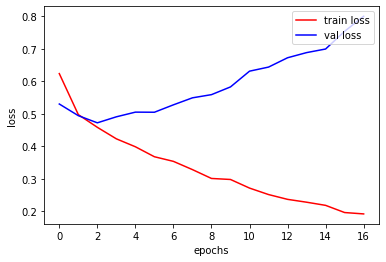

In [67]:
import matplotlib.pyplot as plt

plt.plot(logs['loss']['train'], color='red', label='train loss')
plt.plot(logs['loss']['val'], color='blue', label='val loss')
plt.legend(loc="upper right")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

## Predict

In [ ]:
# Denotes the transformatioin to be applied

Text = data.Field(sequential=True, use_vocab=True, tokenize='spacy', batch_first=True)
# for use_vocab
# https://stackoverflow.com/questions/56251267/bucketiterator-throws-field-object-has-no-attribute-vocab#comment111668766_56251599
Labels = data.LabelField(dtype=torch.int64, batch_first=True, use_vocab=False)

In [ ]:
fields = {'text': ('text', Text), 'id': ('id', Labels)}

In [ ]:
test_data=data.TabularDataset(path = 'cleaned test.csv',format = 'csv',fields = fields)
Text.build_vocab(test_data,min_freq=3,vectors="glove.6B.100d")  
Labels.build_vocab(test_data)

In [ ]:
Labels.vocab.itos[2], Text.vocab.itos[2]

In [ ]:
# Commonly used words
# print(Text.vocab.freqs.most_common(10))  

In [ ]:
for x in test_data:
    print(x.text, x.id)
    break

In [ ]:
# Labels.vocab.freqs.most_common(3)
# Labels.vocab.

In [ ]:
#Load an iterator
test_iterator = data.BucketIterator(
    test_data, 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [ ]:
# list(test_data)
cnt = 10
for _, x in zip(list(range(cnt)), test_data):
    print(x.text, x.id)
    # out = model(x.text)
    # print(out)
    # break

In [ ]:
for x in test_iterator:
    # print(x.text, x.id)
    # print(x.id, x.id.shape)
    out = model(x.text)
    print(out[:5])
    out = torch.argmax(out, dim=1)
    print(out[:5])
    break

In [ ]:
preds = pd.DataFrame(columns=['id', 'target'])

In [ ]:
model.eval()

for batch in test_iterator:
    inputs, ids = batch.text.cuda(), batch.id
    outs = model(inputs)
    outs = torch.argmax(outs, dim=1)

    for out, id in zip(outs, ids):
        preds = preds.append({'id': id.item(), 'target': Labels.vocab.itos[out.item()]}, ignore_index=True)

In [ ]:
preds.target.replace([0, '1000'], [0, 1], inplace=True)
preds.tail()

In [ ]:
# preds['new'] = preds.apply(lambda row: 1 if row.target == '1000' else 0, axis=1)
# preds.drop('new', inplace=True)
# preds = preds['id', 'target']

In [ ]:
len(preds), len(test_data)

In [ ]:
preds.to_csv('preds.csv', index=False)

In [ ]:
'1000' in set(preds['id']) or 1000 in set(preds['id'])

In [ ]:
org = set(pd.read_csv('test.csv')['id'])
org == set(preds['id']), len(org - set(preds['id']))

In [ ]:
{'Rank': 1170, 'score': 0.537}

### Improvements

- clean the data, remove [. , # ] etc
- split the dataset such that train and test labels have same positive and negative

In [ ]:
# ! unzip nlp-getting-started.zip

In [55]:
x = torch.randn(3)

In [56]:
x.requires_grad = True
x.requires_grad

True

In [57]:
x.long().requires_grad

False

In [59]:
# torch.long(x).requires_grad
x.to(dtype=torch.long).requires_grad

False

In [61]:
x.type(torch.LongTensor).requires_grad

False